In [9]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

Meshcat url:  http://127.0.0.1:7001/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [11]:
# Convert dataset to observed node sets (caching output) and draw a few examples.

RECONVERT_DATASET = True
DATASET_YAML_FILE = "sink/saved_scenes.yaml"
DATASET_SAVE_FILE = "observed_node_sets.dat"

if RECONVERT_DATASET or not os.path.exists(DATASET_SAVE_FILE):
    type_map = {
        "bin": DishBin
    }
    model_map = {
    }
    for model_type_set in [PlateModels, CupModels, BowlModels]:
        for model_type in model_type_set:
            # Have to cut off the "sink" folder to match model names;
            # dataset management is ugly and should get reorganized...
            model_map[os.path.join(*model_type.sdf.split("/")[1:])] = model_type
    observed_node_sets = convert_scenes_yaml_to_observed_nodes(DATASET_YAML_FILE, type_map, model_map)
    print("Saving...")
    with open(DATASET_SAVE_FILE, "wb") as f:
        pickle.dump(observed_node_sets, f)

print("Loading...")
with open(DATASET_SAVE_FILE, "rb") as f:
    observed_node_sets = pickle.load(f)

draw_scene_tree_contents_meshcat(
    SceneTree.make_from_observed_nodes(observed_node_sets[0]),
    zmq_url=vis.window.zmq_url, prefix="observed/contents"
)

Saving...
Loading...


In [12]:
total_of_each_type = {"DishBin": 0}
for model_type_set in [PlateModels, CupModels, BowlModels]:
    for model_type in model_type_set:
        total_of_each_type[model_type.__name__] = 0
for observed_nodes in observed_node_sets:
    for node in observed_nodes:
        total_of_each_type[type(node).__name__] += 1
print(total_of_each_type)

{'DishBin': 30, 'sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring': 12, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado': 12, 'sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise': 21, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise': 0, 'sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue': 12, 'sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow': 12, 'sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White': 14, 'sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl': 9, 'sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue': 10, 'sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose': 8}


In [13]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)

grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)

tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()

vis["sample"].delete()
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/contents")
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/structure")

In [14]:
observed_node_set_test = [
    BowlModels[0](drake_tf_to_torch_tf(RigidTransform(
        p=[0.5, 0.0, 0.1],
        R=UniformlyRandomRotationMatrix(RandomGenerator(0))))
    ),
    DishBin(drake_tf_to_torch_tf(
        RigidTransform(p=[0.5, 0., 0.]))
    )
]
print([type(node).__name__ for node in observed_node_set_test])

['sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl', 'DishBin']


In [15]:
supertree = grammar.make_super_tree(max_recursion_depth=6)
print("Supertree size ", len(supertree.nodes))

Supertree size  119


In [16]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
trees = get_optimized_trees_from_mip_results(infer_mle_tree_with_mip(grammar, observed_node_sets[0], N_solutions=5, max_recursion_depth=6, verbose=True))
vis["parses"].delete()
for k, tree in enumerate(trees):
    #draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/contents/%d" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k)

Starting setup.
Activation vars allocated.
Continuous variables allocated.
Setup time:  0.23923373222351074
Num vars:  1704
Num constraints:  3764
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Tue Sep 28 16:55:34 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 2548 rows, 1704 columns and 10653 nonzeros
Model fingerprint: 0x8d3db8a5
Model has 90 quadratic objective terms
Variable types: 1548 continuous, 156 integer (156 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+01]
  Objective range  [8e-31, 1e+02]
  QObjective range [1e+01, 3e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 2091 rows and 1427 columns
Presolve time: 0.02s
Presolved: 457 rows, 277 columns, 2096 nonzeros
Presolved model has 60 quadratic objective terms
Variable types: 267 continuous, 10 integer (10 binary)

Root relaxation: objective -1.430725e+02, 665 iterations, 0.00 seconds

    Nodes    | 

In [17]:
print(len(trees))

5


# MIPMAP-EM alternation

In [18]:
em = EMWrapper(grammar, observed_node_sets)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=1, num_workers=10, max_recursion_depth=6)

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose): None
    (PlateStack): ConstrainedParameter()
    (sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue): None
    (DishBin): ConstrainedParameter()
    (Plate): ConstrainedParameter()
    (sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl): None
    (AssortedPlateStacks): ConstrainedParameter()
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise): None
    (Cup): ConstrainedParameter()
    (AssortedObjects): ConstrainedParameter()
    (sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado): None
    (sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White): None
    (Object): ConstrainedParameter()
    (sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Pla

Final params:  tensor([0.9999, 0.5000])


Final params:  tensor([0.1772, 0.3418, 0.4810])


Plate
Final params:  tensor([2.6664e-01, 2.6664e-01, 4.6662e-01, 9.9990e-05])


PlateStack
Final params:  tensor([0.7097])
mean tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.0044,  0.0016,  0.0124],
        [-0.0090,  0.0021,  0.0133],
        [-0.0134,  0.0021,  0.0136],
        [-0.0178,  0.0021,  0.0141],
        [-0.0244,  0.0012,  0.0153],
        [-0.0298,  0.0011,  0.0154],
        [-0.0346,  0.0011,  0.0154],
        [-0.0390,  0.0011,  0.0154],
        [-0.0430,  0.0012,  0.0154],
        [-0.0463,  0.0012,  0.0154]])
0:xyz:mean final: tensor([-0.0463,  0.0012,  0.0154])
variance tensor([[0.0100, 0.0100, 0.0500],
        [0.0005, 0.0043, 0.0002],
        [0.0006, 0.0043, 0.0002],
        [0.0007, 0.0045, 0.0002],
        [0.0007, 0.0046, 0.0003],
        [0.0011, 0.0044, 0.0004],
        [0.0013, 0.0045, 0.0004],
        [0.0014, 0.0045, 0.0004],
        [0.0016, 0.0046, 0.0004],
        [0.0018, 0.0046, 0.0004],
        [0.0022, 0.0046, 0.0004]])
0:xyz:variance final: tensor([0.0022, 0.0046, 0.0004])
0:rot:M final: tensor([[ 0.0434, -0.0105, -0.4213, 

/home/gizatt/projects/spatial_scene_grammars/spatial_scene_grammars/parameter_estimation.py:767: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


AssortedPlateStacks
Final params:  tensor([0.6818])
mean tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.0055,  0.0223,  0.0176],
        [-0.0018,  0.0256,  0.0184],
        [ 0.0022,  0.0258,  0.0185],
        [ 0.0062,  0.0256,  0.0186],
        [ 0.0076,  0.0220,  0.0186],
        [ 0.0121,  0.0216,  0.0186],
        [ 0.0167,  0.0216,  0.0186],
        [ 0.0208,  0.0217,  0.0186],
        [ 0.0243,  0.0217,  0.0186],
        [ 0.0270,  0.0217,  0.0186]])
0:xyz:mean final: tensor([0.0270, 0.0217, 0.0186])
variance tensor([[1.0000e-01, 1.0000e-01, 5.0000e-02],
        [1.6412e-03, 1.9336e-02, 9.5902e-05],
        [1.4724e-03, 1.5415e-02, 5.3140e-05],
        [1.2948e-03, 1.4325e-02, 2.1474e-05],
        [1.2023e-03, 1.3645e-02, 3.6568e-06],
        [1.1324e-03, 1.2423e-02, 1.0000e-06],
        [8.9011e-04, 1.2016e-02, 1.0000e-06],
        [6.8799e-04, 1.1783e-02, 1.0000e-06],
        [5.0238e-04, 1.1606e-02, 1.0000e-06],
        [3.1598e-04, 1.1467e-02, 1.0000e-06],
        [1.4275

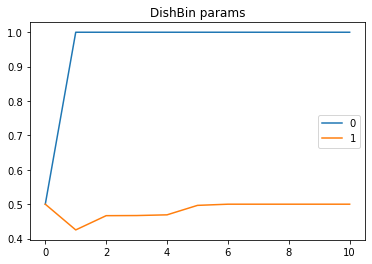

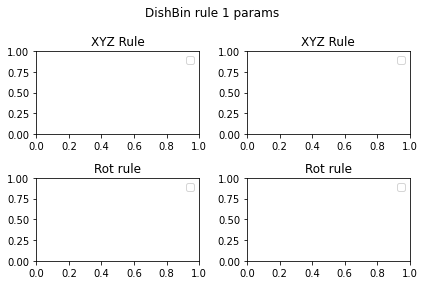

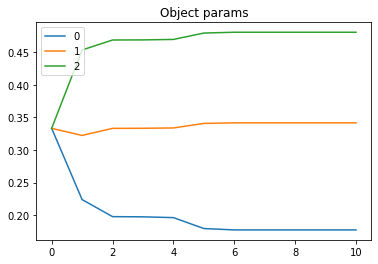

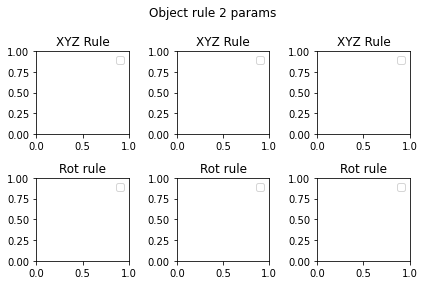

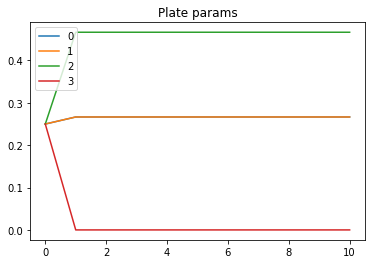

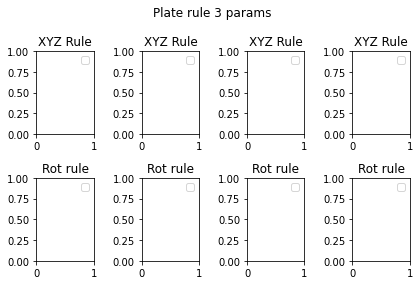

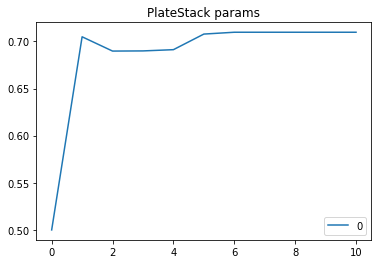

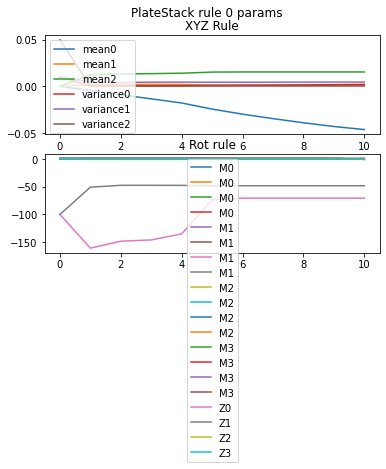

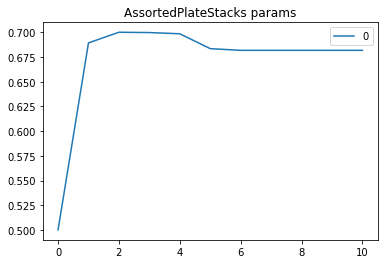

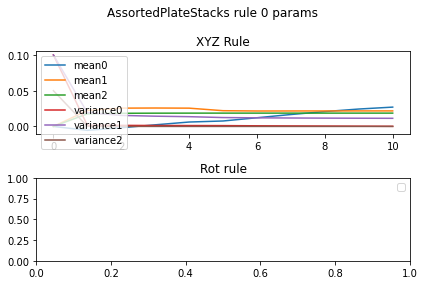

In [22]:
em.plot_grammar_parameter_history(DishBin)
em.plot_grammar_parameter_history(Object)
print("Plate")
em.plot_grammar_parameter_history(Plate)
print("PlateStack")
em.plot_grammar_parameter_history(PlateStack)
print("AssortedPlateStacks")
em.plot_grammar_parameter_history(AssortedPlateStacks)

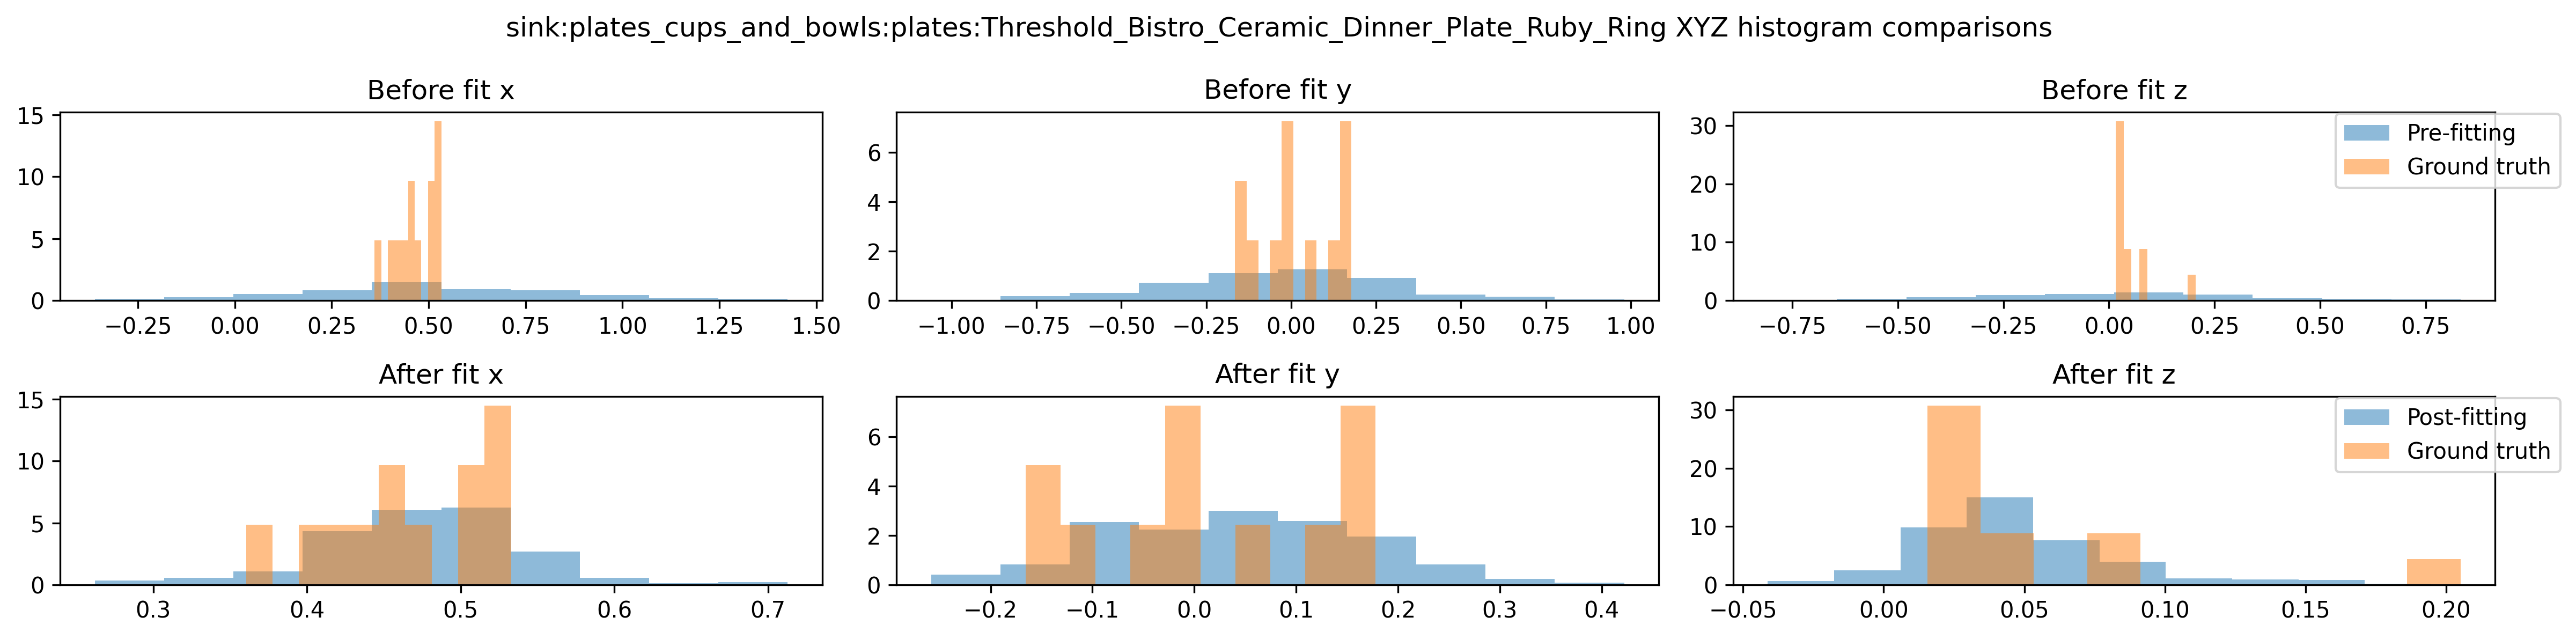

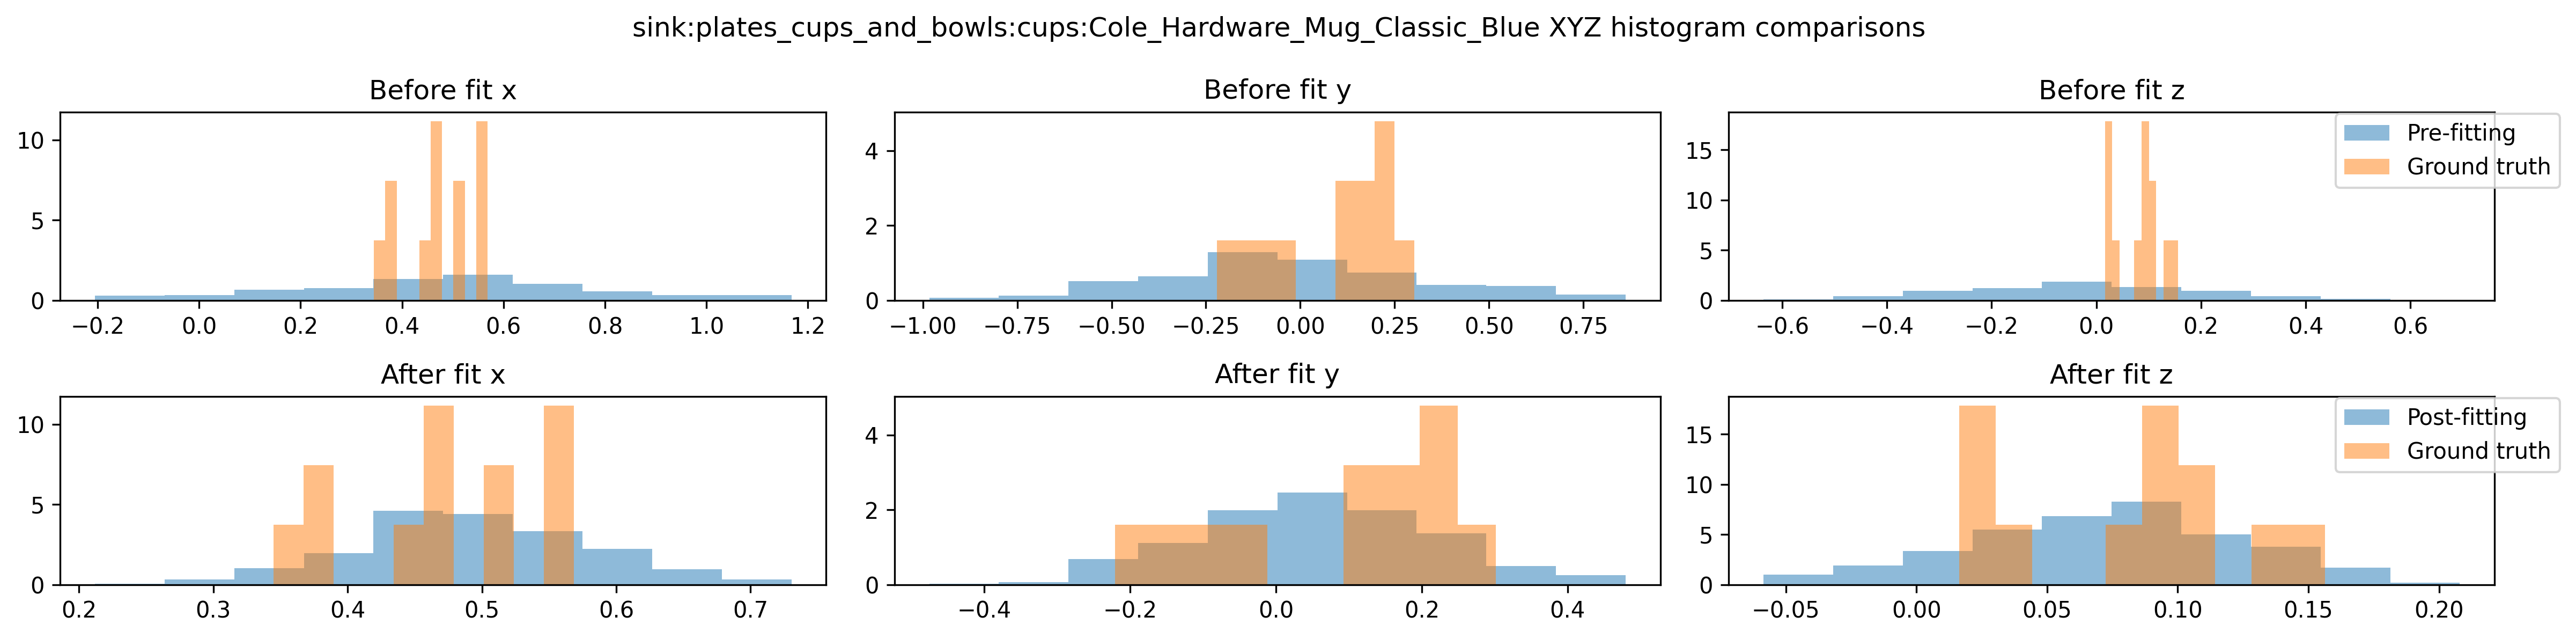

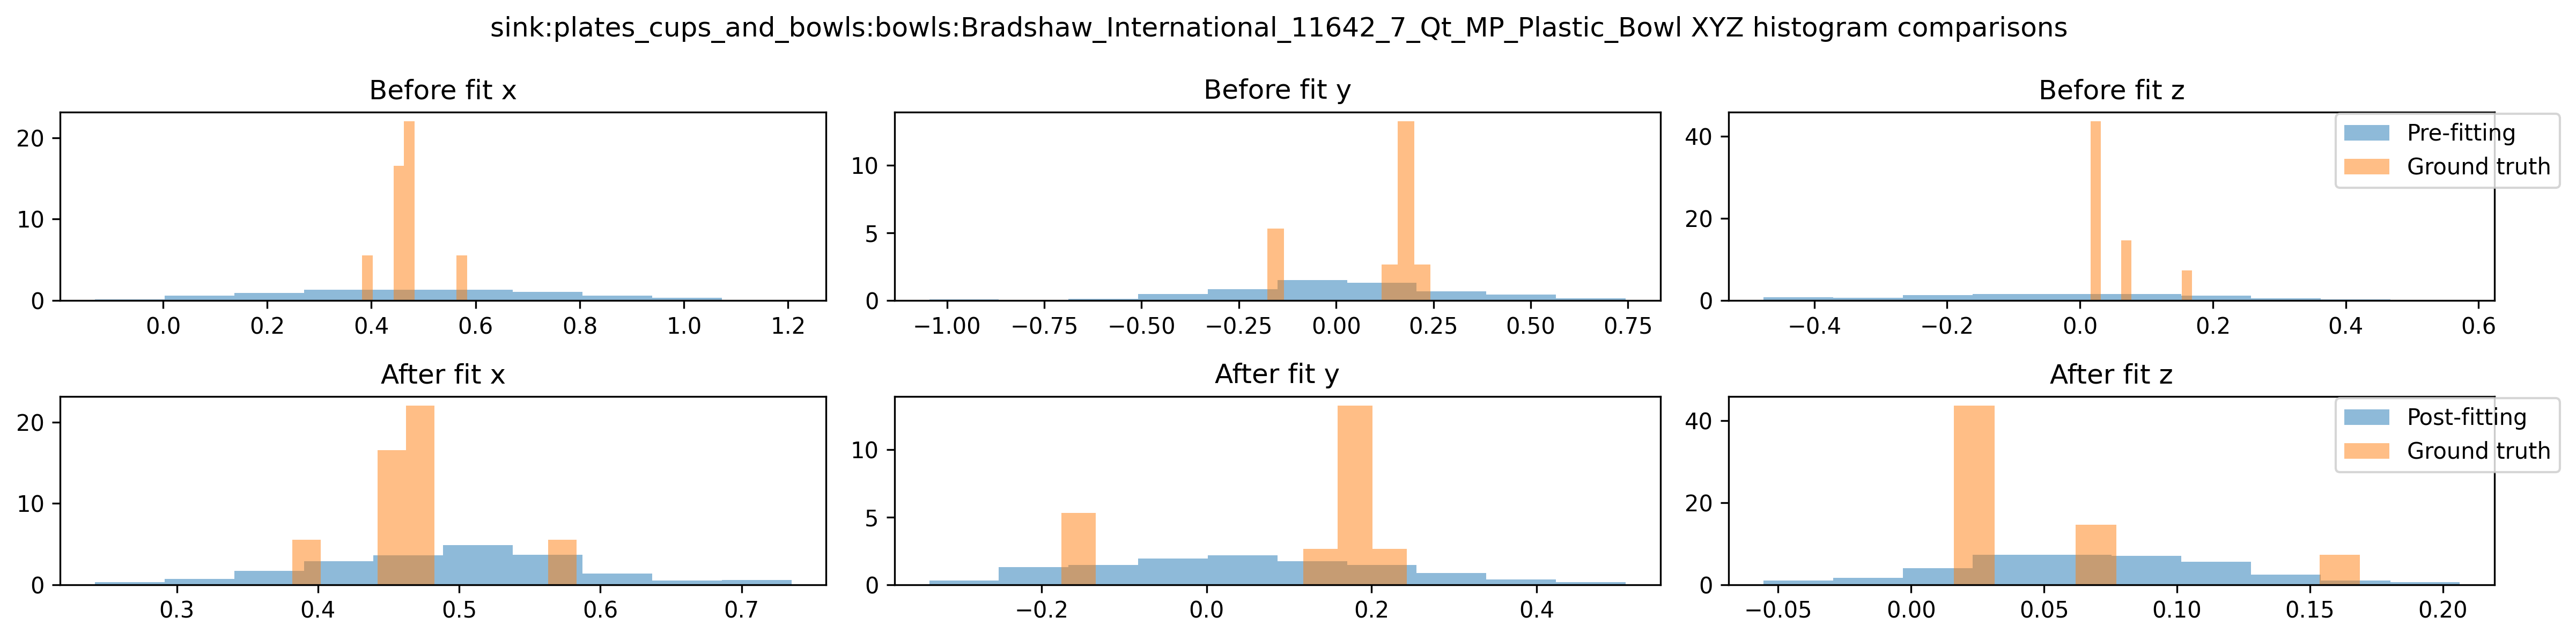

In [20]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(em, N_samples=100):
    pre_fit_samples= []
    em.grammar.load_state_dict(em.grammar_iters[0])
    for k in range(N_samples):
        pre_fit_samples.append(em.grammar.sample_tree(detach=True))
    fit_samples = []
    em.grammar.load_state_dict(em.grammar_iters[-1])
    for k in range(N_samples):
        fit_samples.append(em.grammar.sample_tree(detach=True))

    for node_type in [PlateModels[0], CupModels[0], BowlModels[0]]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(em, N_samples=1000)

In [21]:
# Draw some samples from the fit posterior
vis["fit_samples"].delete()
for k in range(5):
    tree = grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/structure" % k)